---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [159]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
from zipfile import ZipFile

# Pytorch essentials
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.transforms import v2

# Utils
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [ ]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

## <font color='#4C5FDA'>**Preprocesamiento de los datos**</font>

### <font color='#52F17F'>**Definición del Dataset usando PyTorch**</font>

In [8]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [365]:
class PatientDataset(Dataset):
  def __init__(self, audio_dir: str, video_dir: str, transform = None, n_frames = FRAMES_PROMEDIO):
    self.audio_dir = audio_dir
    self.video_dir = video_dir
    self.transform = transform
    self.n_frames = n_frames
    self.audios = os.listdir(audio_dir) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.audios)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos el audio de la lista
    audio_path = os.path.join(self.audio_dir, self.audios[index])

    # Leemos el audio
    audio = preprocess_audio(audio_path)

    """ Carga de los frames """

    # Entramos a la carpeta y conseguimos los frames de la lista.
      # La razon por la que uso la misma lista de audios es porque el audio y el vídeo
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ audios: AudioVisualData_v7/Control/C0/Phonemes/audio/C0-1-Pakata.mp3 """
    """ vídeo: AudioVisualData_v7/Control/C0/Phonemes/frames/C0-1-Pakata.mov """
    video_path = os.path.join(self.video_dir, self.audios[index].replace(".mp3", ".mov"))

    frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    frames = []
    for frame in frames_path:
      frame_path = os.path.join(self.video_dir, self.audios[index].replace(".mp3", ".mov"), frame)
      # print(frame_path)
      frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
      frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
      frame = frame / 255. # Normalizamos entre 0 y 1
      frames.append(frame)

    frames = np.expand_dims(np.stack(frames),axis=1)
    frames = torch.from_numpy(frames)
    #print(frames.shape)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = self.audio_dir.split('/')[1]
    if label == 'Parkinson':
      label = 1.0
    else:
      label = 0.0

    """ Consiguiendo el paciente para GroupKfold """
    patient = self.audio_dir.split('/')[2]

    """ Data augmentation """
    if self.transform:
      frames = self.transform(frames)
      # Aplicamos las transformaciones a la máscara e imagen
      # augmentations = self.transform(image=img, mask=mask)

      # # Lo anterior nos devuelve un diciconario, entonces conseguimos la máscara e imagen de ese diccionario
      # img, mask = augmentations['image'], augmentations['mask']
      # img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
      # mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)
    return patient, audio, frames, label

#### <font color="6600CC">**Ejemplo de uso**</font>

In [264]:
audio_dir = 'AudioVisualData_v7/Control/C0/Phonemes/audio'
video_dir = 'AudioVisualData_v7/Control/C0/Phonemes/frames'
prueba = PatientDataset(audio_dir=audio_dir, video_dir=video_dir)
print(prueba.__len__())
patient, audio, frames, label = prueba.__getitem__(8)
print(patient, label)

9
torch.Size([14, 1, 112, 112])
C0 0.0


### <font color='#52F17F'>**Constantes de las rutas Principales para cada clase**</font>

In [35]:
CONTROL_PATH = "AudioVisualData_v7/Control"
PARKINSON_PATH = "AudioVisualData_v7/Parkinson"

#### <font color="6600CC">**Creación de los directorios (rutas) para cada Clase**</font>

In [242]:
dirs_control = []
control_registros = 0
for patient in os.listdir(CONTROL_PATH):
  # print(patient)
  for record_type in os.listdir(os.path.join(CONTROL_PATH, patient)):
    # print(os.path.join(CONTROL_PATH, patient, record_type))
    dirs_control.append(os.path.join(CONTROL_PATH, patient, record_type))
    _, _, files = next(os.walk(os.path.join(CONTROL_PATH, patient, record_type, "audio")))
    # print(files)
    control_registros += len(files)

dirs_parkinson = []
parkinson_registros = 0
for patient in os.listdir(PARKINSON_PATH):
  # print(patient)
  for record_type in os.listdir(os.path.join(PARKINSON_PATH, patient)):
    #   print(os.path.join(PARKINSON_PATH, patient, record_type))
    dirs_parkinson.append(os.path.join(PARKINSON_PATH, patient, record_type))
    _, _, files = next(os.walk(os.path.join(PARKINSON_PATH, patient, record_type, "audio")))
    parkinson_registros += len(files)

# Imprimo la cantidad de pacientes y datos que tenemos
print(f"Cantidad de pacientes de control: {len(dirs_control)/3}")
print(f"Cantidad de audios de control: {control_registros}")
print(f"Cantidad de frames de control: {control_registros*14}")
print()
print(f"Cantidad de pacientes de parkinson: {len(dirs_parkinson)/3}")
print(f"Cantidad de audios de parkinson: {parkinson_registros}")
print(f"Cantidad de frames de parkinson: {parkinson_registros*14}")

Cantidad de pacientes de control: 7.0
Cantidad de audios de control: 546
Cantidad de frames de control: 7644

Cantidad de pacientes de parkinson: 7.0
Cantidad de audios de parkinson: 545
Cantidad de frames de parkinson: 7630


#### <font color="6600CC">**Definición de las transformaciones usadas en Data Augmentation**</font>

In [343]:
transforms = v2.Compose([
    #v2.ToImage(),
    v2.RandomInvert(p=0.5),
    v2.RandomAutocontrast(p=0.4),
    #v2.FiveCrop(112),
    v2.RandomErasing(),
    #v2.RandomResizedCrop(size=(224, 224), antialias=True),
    #v2.RandomHorizontalFlip(p=1),
    #v2.RandomVerticalFlip(p=0.5),
    #v2.GaussianBlur(kernel_size=3)
])

#### <font color="6600CC">**Creación de los Datasets**</font>

In [367]:
datasets_control = []
for ruta in dirs_control:
  audio_dir = ruta + "/audio"
  video_dir = ruta + "/frames"
  datasets_control.append(PatientDataset(audio_dir=audio_dir, video_dir=video_dir, transform = transforms))

datasets_parkinson = []
for ruta in dirs_parkinson:
  audio_dir = ruta + "/audio"
  video_dir = ruta + "/frames"
  datasets_parkinson.append(PatientDataset(audio_dir=audio_dir, video_dir=video_dir, transform=transforms))

In [368]:
control_concat = ConcatDataset(datasets_control)
parkinson_concat = ConcatDataset(datasets_parkinson)

### <font color='#52F17F'>**Ejemplo Visualización (Video y Audio)**</font>

In [338]:
def plot_frame_strip(frames, rows=2, cols=7):
    """
    Hace un plot de la tira de frames en una matriz de imágenes.

    Args:
        frames (np.ndarray): Tensor de frames con forma (num_frames, height, width, channels).
        rows (int): Número de filas en la tira de frames.
        cols (int): Número de columnas en la tira de frames.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(frames):
                axes[i, j].imshow(np.transpose(frames[idx], (1, 2, 0)), cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(f"Frame: {idx}")
    plt.show()

torch.Size([14, 1, 112, 112])


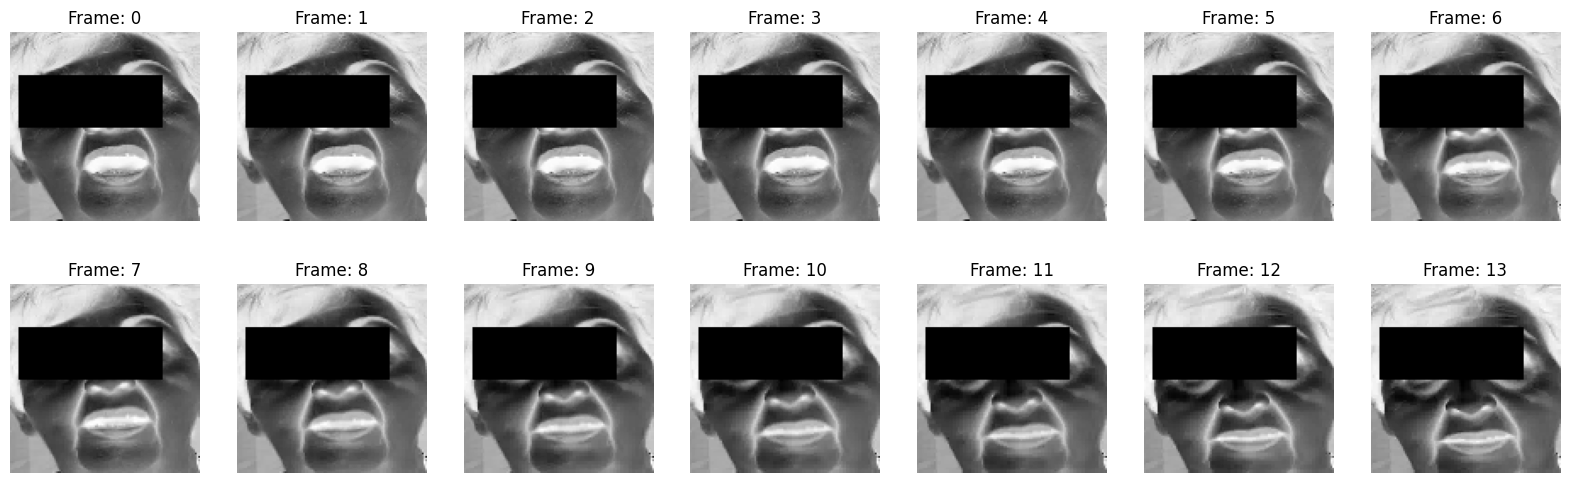

In [370]:
patient, audio, frames, label = parkinson_concat.__getitem__(2)
print(frames.shape)
#print(frames.numpy().shape, frames.numpy().dtype)
frames = frames.numpy()
plot_frame_strip(frames)

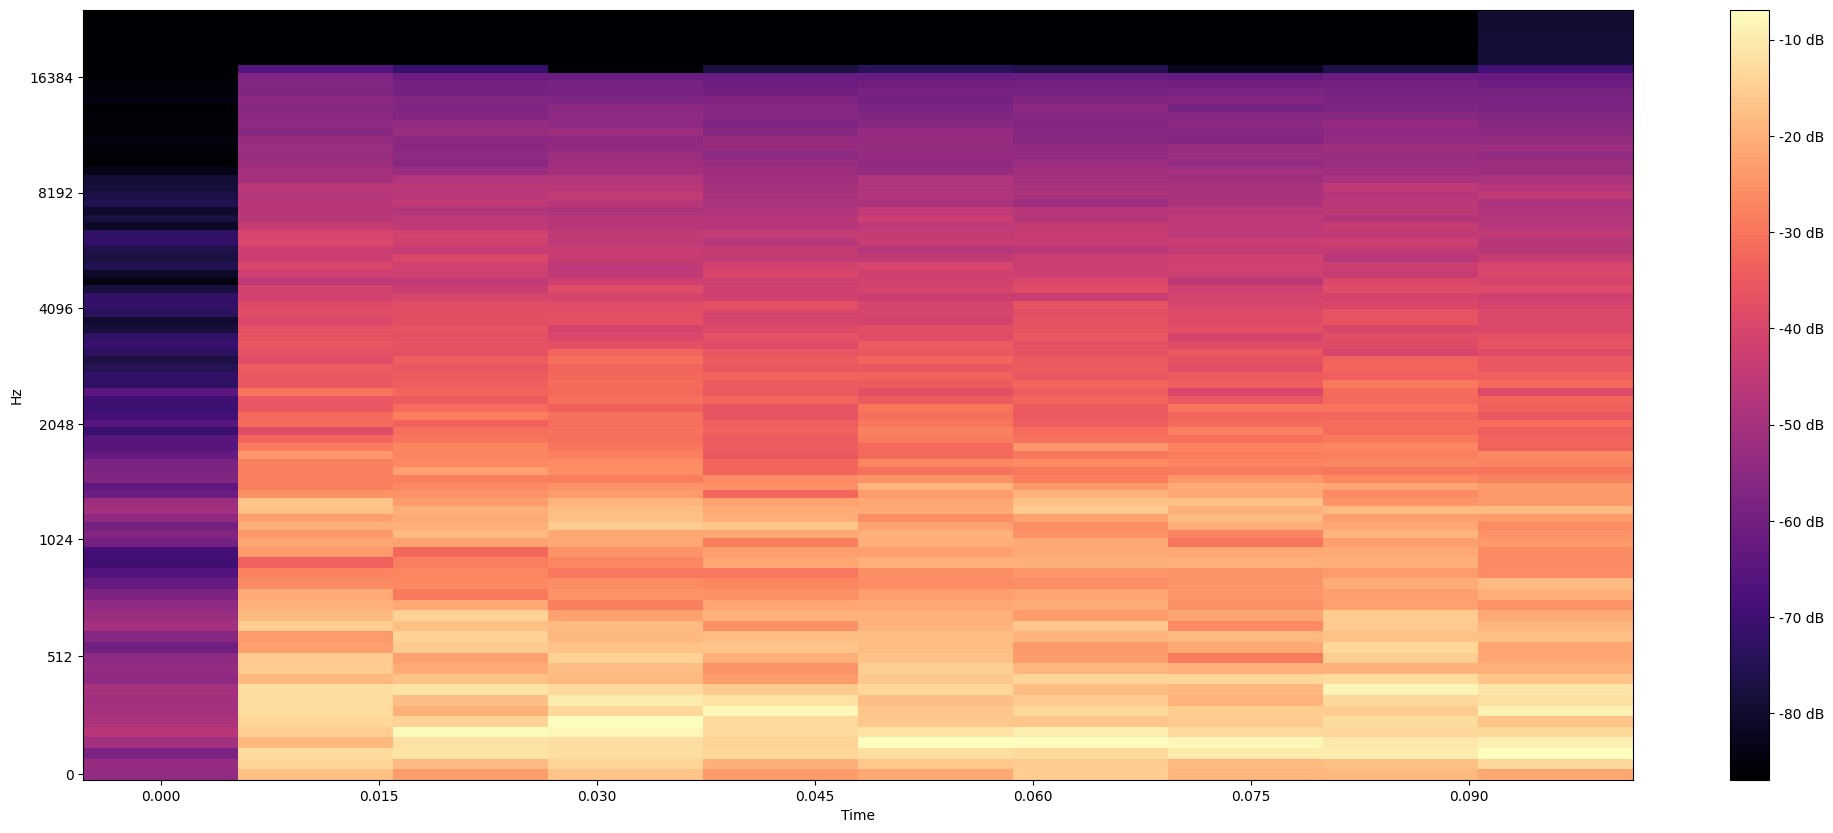

In [362]:
plt.figure(figsize=(25,10))
librosa.display.specshow(audio, y_axis='mel', x_axis='time', sr=48000)
plt.colorbar(format="%+2.f dB")
plt.show()